# **COLLEGAMENTO AL DRIVE** 👌 ◀

In [2]:
from google.colab import drive
drive.mount('/content/drive')                                                   # Indirizzo base del drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **LIBRERIE** 👌 ◀

In [3]:
!reset                                                # Forza il restart

In [4]:
# import the necessary packages
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [5]:
# import the necessary packages
from torch.nn import functional as F


In [6]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2

In [7]:
import numpy as np                                    # Importa Numpy
import skimage.io as io                               # Importa il modulo Input/ouput di SK-Image
from skimage.transform import resize                  # Importa il modulo resize da SK-Image
from os import listdir                                # Importa il modulo listdir da OS

import matplotlib.pyplot as plt                       # Importa il modulo  pyplot di MatPlotLib

from PIL import Image                                 # Importa il modulo Image da PIL


In [8]:
from functools import lru_cache                       # Importa il modulo lru_cache da functools

In [9]:
!pip install segmentation-models-pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=c3feead12b8bf4bfd799fc95e24033124121cc232134db7f54fde48ae1d3a773
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c1dd3e957d5a2ed0da2821f676d533e9e48382219309be9605768bc8468a1ccf
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [10]:
import torch
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# **PATH** 👌 ◀

In [11]:
base_path = '/content/drive/MyDrive/'                                           # Path progetto
dataset_path = base_path + 'dataset/'                                           # Path dataset
model_path = base_path + 'ResUnet-pytorch/'                                     # Path del modello (cwd)
data_graph = model_path + 'grafici/'                                             # Path grafici
data_weights = model_path + 'pesi/'                                             # Path pesi

In [12]:
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = dataset_path+'0_train/'
MASK_DATASET_PATH = dataset_path+'0_train_bi/'


imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))


validImg = sorted(list(paths.list_images('/content/drive/MyDrive/dataset/2_test/')))
validMask = sorted(list(paths.list_images('/content/drive/MyDrive/dataset/2_test_bi/')))

In [13]:
# Check if the validation image directory exists and contains files
if os.path.exists('/content/drive/MyDrive/dataset/2_test/') and len(os.listdir('/content/drive/MyDrive/dataset/2_test/')) > 0:
    print("Validation image directory exists and is not empty.")
else:
    print("Validation image directory is either missing or empty. Please check the path.")

# Do the same for the mask directory
if os.path.exists('/content/drive/MyDrive/dataset/2_test_bi/') and len(os.listdir('/content/drive/MyDrive/dataset/2_test_bi/')) > 0:
    print("Validation mask directory exists and is not empty.")
else:
    print("Validation mask directory is either missing or empty. Please check the path.")

Validation image directory exists and is not empty.
Validation mask directory exists and is not empty.


# **ISTANZIAMENTO RETE** 👌 ◀

In [14]:

'''
parametri ignorati/non visibili con pytorch ma settabili con keras
                weights=None,
                encoder_features='default',
                decoder_block_type='upsampling',
                decoder_filters=(256, 128, 64, 32, 16),
                decoder_use_batchnorm=True
'''

# Definizione della rete Unet con backbone ResNet18
BACKBONE = 'resnet18'

model = smp.Unet(
    encoder_name=BACKBONE,                            # Modello utilizzato come estrattore di feature
    encoder_weights='imagenet',                       # Pre-formazione su ImageNet
    in_channels=3,                                    # Input con 3 canali (immagini RGB)
    classes=1,                                        # Numero di classi di output (1 per segmentazione binaria)
    activation='sigmoid'                              # Output tra [0, 1] per stabilità nel training
)

# Congelamento dei pesi del backbone
for param in model.encoder.parameters():
    param.requires_grad = False

# Definizione della funzione di perdita (binary cross-entropy)
loss_fn = nn.BCELoss()

# Ottimizzatore (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.06)


# Funzione di training
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    total_iou = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, masks)

        # Backward pass e ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # update our training history

    return total_loss / len(dataloader)


def validate(model, dataloader, loss_fn, device):
    # initialize the validation loss
    total_loss = 0
    loss = 0
    # turn on evaluation mode
    model.eval()
    # switch off autograd
    with torch.no_grad():
      # loop over the validation set
      for (x, y) in validLoader:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # make the predictions and calculate the validation loss
        pred = model(x)
        loss += loss_fn(pred, y)
        total_loss += loss.item()
        # update our training history
    return total_loss / len(dataloader)


# Inizializzazione del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [15]:
#IGNORED
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (int):
    """

    def __init__(self, output_size):
      self.output_size = output_size

    def __call__(self, sample):
      image, mask = sample['image'], sample['mask']
      dimension = self.output_size

      #mask
      msk = (mask[ : , : , 0])%2                                                                 # Porta l'immagine stretchata da 3 canali a 1 canale
      msk_stretched = resize(msk, (dimension, dimension), order=0)                            # Stretcha le immagini con interpolazione Nearest-Neighbour
      msk_stretchedbn = np.expand_dims(msk_stretched, axis=-1)                                # Aggiunge la quarta dimensione

      #image
      img_stretched = resize(image, (dimension, dimension), order=0)                            # Stretcha le immagini con interpolazione Nearest-Neighbour

      return {'image': img_stretched, 'mask': msk_stretchedbn}


In [16]:
# Esempio di DataLoader (da riempire con dataset specifico)
from google.colab.patches import cv2_imshow
class SegmentationDataset(Dataset):

  def __init__(self, image_path, mask_path, transform=None):
    """
    Arguments:
        image_path (string):
        mask_path (string):
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.image_path = image_path
    self.mask_path = mask_path
    self.transforms = transform


  def __len__(self):
    # return the number of total samples contained in the dataset
    return len(self.image_path)


  def __getitem__(self, idx):
    # grab the image path from the current index
    imagePath = self.image_path[idx]
    # load the image from disk, swap its channels from BGR to RGB,
    # and read the associated mask from disk in grayscale mode
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(self.mask_path[idx], 0)
    # check to see if we are applying any transformations
    if self.transforms is not None:
      # apply the transformations to both image and its mask
      image = self.transforms(image)
      mask = self.transforms(mask)

    # return a tuple of the image and its mask
    return (image, mask)


    def show_item(self, idx):
      # grab the image path from the current index
      imagePath = self.image_path[idx]
      # load the image from disk, swap its channels from BGR to RGB,
      # and read the associated mask from disk in grayscale mode
      image = cv2.imread(imagePath)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      mask = cv2.imread(self.mask_path[idx], 0)
      # check to see if we are applying any transformations
      if self.transforms is not None:
        # apply the transformations to both image and its mask
        image = self.transforms(image)
        mask = self.transforms(mask)

      image = image.permute(1, 2, 0)
      mask = mask.permute(1, 2, 0)

      print(image.shape)
      print(mask.shape)
      print(image.type)
      print(mask.type)
      # Display the image
      cv2_imshow(np.array(image))
      cv2_imshow(np.array(mask))




In [17]:

#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
#https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html
from torchvision.transforms import InterpolationMode, Compose, ToPILImage, Resize, ToTensor, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation

# define transformations
transformations = Compose([
    ToPILImage(),
 	  Resize((256,256),interpolation=InterpolationMode.NEAREST),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomRotation(degrees=10),
    ToTensor()
    ])

transformed_dataset_train = SegmentationDataset(image_path=imagePaths,
                                           mask_path=maskPaths,
                                           transform=transformations
                                           )



transformed_dataset_valid = SegmentationDataset(image_path=validImg,
                                           mask_path=validMask,
                                           transform=transformations
                                           )

print(f"[INFO] found {len(transformed_dataset_train)} examples in the training set...")
print(f"[INFO] found {len(transformed_dataset_valid)} examples in the validation set...")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

#https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(
    transformed_dataset_train,
    batch_size=5,
    shuffle=True,
    pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count()
    )

validLoader = DataLoader(
    transformed_dataset_valid,
    batch_size=5,
    shuffle=False,
    pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count()
    )


[INFO] found 1531 examples in the training set...
[INFO] found 202 examples in the validation set...


In [18]:
#transformed_dataset.show_item(0) #da aggiustare



# **TRAIN** 👌

In [ ]:
#first train
num_epochs = 1

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    print(f"Epoch {epoch}: Loss = {train_loss}")

    # Salva l'intero modello per ogni epoca
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss
                }, data_weights + 'epoca-' + str(epoch) + '.pth')

    with open( data_graph + 'train_loss.npy', 'ab') as f:             # ab = append binary
      np.save(f, train_loss)



Epoch 1: Loss = 0.05871081055242095


In [ ]:
#next trainings
PATH = '/content/drive/MyDrive/ResUnet-pytorch/pesi/epoca-120.pth'

checkpoint = torch.load(PATH, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
print(last_epoch,last_loss)

num_epochs = 200

for epoch in range(last_epoch+1, num_epochs):

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    print(f"Epoch {epoch}: Loss = {train_loss}")

    # Salva l'intero modello per ogni epoca
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss
                }, data_weights + 'epoca-' + str(epoch) + '.pth')


    with open( data_graph + 'train_loss.npy', 'ab') as f:             # ab = append binary
      np.save(f, train_loss)


    valid_loss = validate(model, validLoader, loss_fn, device)
    print(f"\tEpoch {epoch}: Validation Loss = {valid_loss}")

    with open( data_graph + 'valid_loss.npy', 'ab') as f:             # ab = append binary
      np.save(f, valid_loss)



120 0.0392070319412537
Epoch 121: Loss = 0.03904011561338113
	Epoch 121: Validation Loss = 0.8035109556484513
Epoch 122: Loss = 0.038684774220523695
	Epoch 122: Validation Loss = 0.7384514626479004
Epoch 123: Loss = 0.03879285362285201
	Epoch 123: Validation Loss = 0.789503799387958
Epoch 124: Loss = 0.03881030232138956
	Epoch 124: Validation Loss = 0.772999293375306
Epoch 125: Loss = 0.03854048906458414
	Epoch 125: Validation Loss = 0.78204178732888
Epoch 126: Loss = 0.03857562582672904
	Epoch 126: Validation Loss = 0.7464418632046479
Epoch 127: Loss = 0.03857372349267674
	Epoch 127: Validation Loss = 0.7823220606348137
Epoch 128: Loss = 0.03861044068192814
	Epoch 128: Validation Loss = 0.7742414656663086
Epoch 129: Loss = 0.03842213402535609
	Epoch 129: Validation Loss = 0.7814890970362396
Epoch 130: Loss = 0.038557764497685706
	Epoch 130: Validation Loss = 0.7799842437592949
Epoch 131: Loss = 0.03857398952330168
	Epoch 131: Validation Loss = 0.7857886590517875
Epoch 132: Loss = 0.03

KeyboardInterrupt: 

# **TEST** 👌

## all functions

In [19]:
# Funzione per calcolare la precision
def precision(mask_img, predicted_img, treshold):
  tp = np.sum((mask_img > treshold) & (predicted_img > treshold))   #entrambi veri
  fp = np.sum( (mask_img < treshold) & (predicted_img > treshold) )   #è vera solo la predetta
  return tp / (tp + fp + 1e-10)

# Funzione per calcolare la recall
def recall(mask_img, predicted_img, treshold):
  tp = np.sum((mask_img > treshold) & (predicted_img > treshold))   #entrambi veri
  fn = np.sum( (mask_img > treshold) & (predicted_img < treshold) )   #è vera solo la mask
  return tp / (tp + fn + 1e-10)

# Funzione per calcolare la F1-score
def f1_score(mask_img, predicted_img, treshold):
  precision_value = precision(mask_img, predicted_img, treshold)
  recall_value = recall(mask_img, predicted_img, treshold)
  return 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-10)

# Funzione per calcolare l'Intersection over Union (IoU)
def iou(mask_img, predicted_img, treshold):
  tp = np.sum((mask_img > treshold) & (predicted_img > treshold))   #entrambi veri
  fp = np.sum( (mask_img < treshold) & (predicted_img > treshold) )   #è vera solo la predetta
  fn = np.sum( (mask_img > treshold) & (predicted_img < treshold) )   #è vera solo la mask
  return tp / (tp + fp + fn + 1e-10)

In [20]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()
	print("\n")

def make_predictions(model, imagePath, maskPath, device, threshold):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (256, 256))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(maskPath,filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		#print(groundTruthPath)
		gtMask = cv2.resize(gtMask, (256, 256))
    # make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(device)

		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		#print(predMask)

		# filter out the weak predictions and convert them to integers
		predMask = (predMask > threshold)

		return orig, gtMask, predMask


def random_test_evaluation(model, number_of_images, threshold):

	# load the image paths in our testing file and randomly select n image paths
	IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/2_test/'
	MASK_TEST_PATH = '/content/drive/MyDrive/dataset/2_test_bi/'
	image_paths = [os.path.join(IMAGE_TEST_PATH, f) for f in os.listdir(IMAGE_TEST_PATH) if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]
	imagePaths = np.random.choice(image_paths, size=number_of_images)

	#threshold = 0.5

	# iterate over the randomly selected test image paths
	for path in imagePaths:

		print(path)

		# make predictions
		orig, gtMask, predMask = make_predictions(model, path, MASK_TEST_PATH, torch.device("cuda" if torch.cuda.is_available() else "cpu"), threshold)

		print(f"Precision: {precision(gtMask, predMask, threshold)}")
		print(f"Recall: {recall(gtMask, predMask, threshold)}")
		print(f"F1-Score: {f1_score(gtMask, predMask, threshold)}")
		print(f"IoU: {iou(gtMask, predMask, threshold)}")

		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)



def full_test_evaluation(model, treshold):

	# load the image paths in our testing file and randomly select n image paths
	IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/2_test/'
	MASK_TEST_PATH = '/content/drive/MyDrive/dataset/2_test_bi/'
	#imagePaths = [os.path.join(IMAGE_TEST_PATH, f) for f in os.listdir(IMAGE_TEST_PATH) if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

	precision_list = []
	recall_list = []
	f1_list = []
	iou_list = []
	#treshold = 0.1

	# iterate over the test image paths: 202 images
	for path in os.listdir(IMAGE_TEST_PATH):

		# make predictions
		orig, gtMask, predMask = make_predictions(model, os.path.join(IMAGE_TEST_PATH, path), MASK_TEST_PATH, device, treshold)

		precision_list.append(precision(gtMask, predMask, treshold))
		recall_list.append(recall(gtMask, predMask, treshold))
		f1_list.append(f1_score(gtMask, predMask, treshold))
		iou_list.append(iou(gtMask, predMask, treshold))

	#salva ciscuna lista in file npy
	data_graph = '/content/drive/MyDrive/ResUnet-pytorch/grafici/'
	with open(data_graph + 'precision_list.npy', 'wb') as f:
			np.save(f, np.array(precision_list))
	with open(data_graph + 'recall_list.npy', 'wb') as f:
			np.save(f, np.array(recall_list))
	with open(data_graph + 'f1_list.npy', 'wb') as f:
			np.save(f, np.array(f1_list))
	with open(data_graph + 'iou_list.npy', 'wb') as f:
			np.save(f, np.array(iou_list))

	return np.mean(precision_list), np.mean(recall_list), np.mean(f1_list), np.mean(iou_list)




def random_test_evaluation_t(model, number_of_images):

	# load the image paths in our testing file and randomly select n image paths
	IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/2_test/'
	MASK_TEST_PATH = '/content/drive/MyDrive/dataset/2_test_bi/'
	image_paths = [os.path.join(IMAGE_TEST_PATH, f) for f in os.listdir(IMAGE_TEST_PATH) if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]
	imagePaths = np.random.choice(image_paths, size=number_of_images)

	threshold_list = [0.2,
	                  0.500,
										0.505,
			 							0.501,
	                  0.502,
										0.503,
										0.504,
										0.505,
										0.506,
										0.507,
										0.508,
										0.509,
										0.6
										]

	# iterate over the randomly selected test image paths
	for path in imagePaths:

		print(path)
		for threshold in threshold_list:
			# make predictions
			orig, gtMask, predMask = make_predictions(model, path, MASK_TEST_PATH, torch.device("cuda" if torch.cuda.is_available() else "cpu"), threshold)

			print(threshold)
			print(f"Precision: {precision(gtMask, predMask, threshold)}")
			print(f"Recall: {recall(gtMask, predMask, threshold)}")
			print(f"F1-Score: {f1_score(gtMask, predMask, threshold)}")
			print(f"IoU: {iou(gtMask, predMask, threshold)}")

			# prepare a plot for visualization
			prepare_plot(orig, gtMask, predMask)


## 4 std images evaluation

In [29]:

def _4_random_test_evaluation(model, threshold):

  # load the image paths in our testing file and randomly select n image paths
  IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/2_test/'
  MASK_TEST_PATH = '/content/drive/MyDrive/dataset/2_test_bi/'
  names = ['01104.jpg','00007.jpg','01925.jpg','01760.jpg']
  imagePaths = [os.path.join(IMAGE_TEST_PATH, f) for f in names if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]

  # iterate over the randomly selected test image paths
  for path in imagePaths:

    print(path)

    # make predictions
    orig, gtMask, predMask = make_predictions(model, path, MASK_TEST_PATH, torch.device("cuda" if torch.cuda.is_available() else "cpu"), threshold)

    print(f"Precision: {precision(gtMask, predMask, threshold)}")
    print(f"Recall: {recall(gtMask, predMask, threshold)}")
    print(f"F1-Score: {f1_score(gtMask, predMask, threshold)}")
    print(f"IoU: {iou(gtMask, predMask, threshold)}")

    # prepare a plot for visualization
    prepare_plot(orig, gtMask, predMask)



<ipython-input-31-1ea11da22663>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))


/content/drive/MyDrive/dataset/2_test/01104.jpg
Precision: 0.34229828850853655
Recall: 0.5379442843419272
F1-Score: 0.41837878217134056
IoU: 0.26452527161075745


/content/drive/MyDrive/dataset/2_test/00007.jpg
Precision: 0.717948717946877
Recall: 0.08888888888886068
F1-Score: 0.15819209037578444
IoU: 0.0858895705521209


/content/drive/MyDrive/dataset/2_test/01925.jpg
Precision: 0.012234910277324134
Recall: 0.04658385093166978
F1-Score: 0.01937984492829065
IoU: 0.009784735812132753


/content/drive/MyDrive/dataset/2_test/01760.jpg
Precision: 0.5621210450887382
Recall: 0.704379057880913
F1-Score: 0.6252605762841609
IoU: 0.45482115779145077




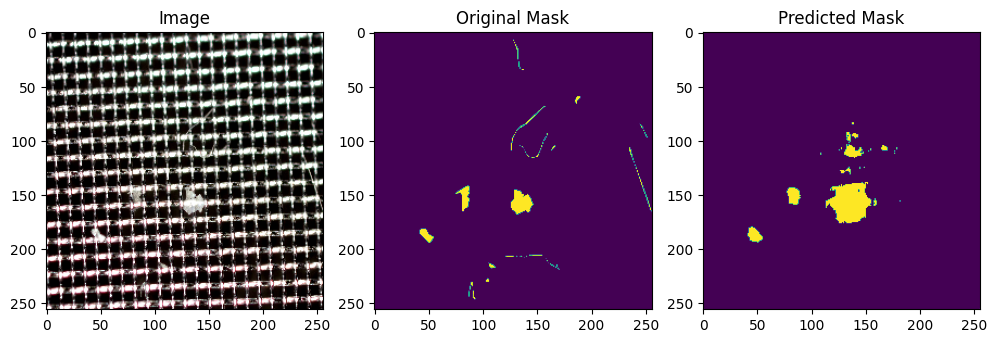

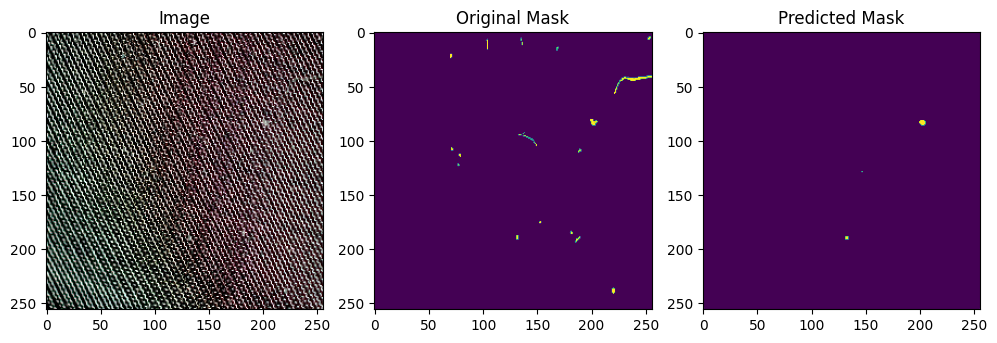

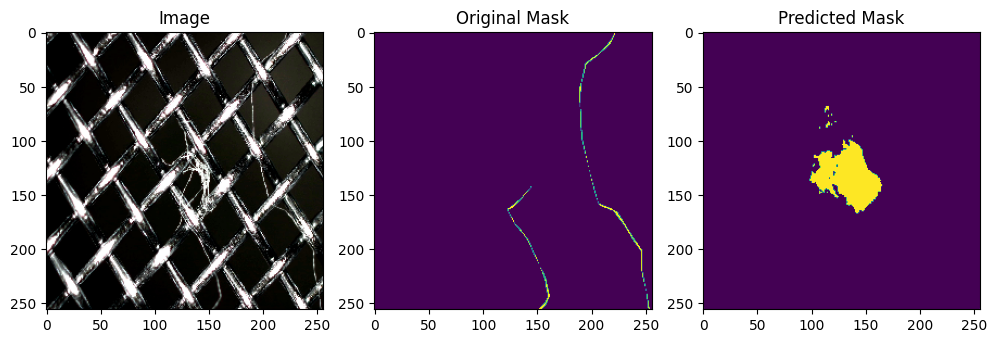

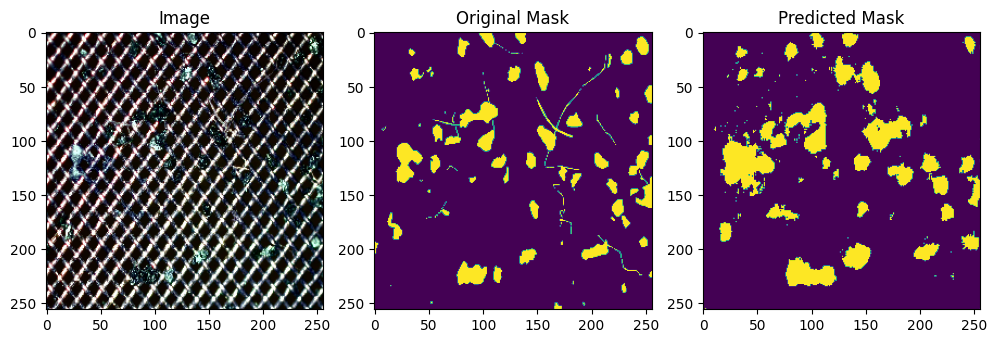

In [31]:
#USAGE random_test_evaluation

# load our model from disk and flash it to the current device
MODEL_PATH = '/content/drive/MyDrive/ResUnet-pytorch/pesi/epoca-145.pth'
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
#print(last_epoch,last_loss)

t = 0.505

_4_random_test_evaluation(model,t)

## random images evaluation

<ipython-input-50-15d655802204>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))


/content/drive/MyDrive/dataset/2_test/01104.jpg
Precision: 0.3582652419861497
Recall: 0.5475504322766045
F1-Score: 0.43313069904029633
IoU: 0.2764306498544968


/content/drive/MyDrive/dataset/2_test/00007.jpg
Precision: 0.325423728813449
Recall: 0.30476190476180803
F1-Score: 0.31475409831060625
IoU: 0.18677042801552785


/content/drive/MyDrive/dataset/2_test/01925.jpg
Precision: 0.02345215759849796
Recall: 0.07763975155278297
F1-Score: 0.036023054719406665
IoU: 0.01834189288334489


/content/drive/MyDrive/dataset/2_test/01760.jpg
Precision: 0.5612020289022819
Recall: 0.8100566376571238
F1-Score: 0.6630483943433172
IoU: 0.4959404600811866




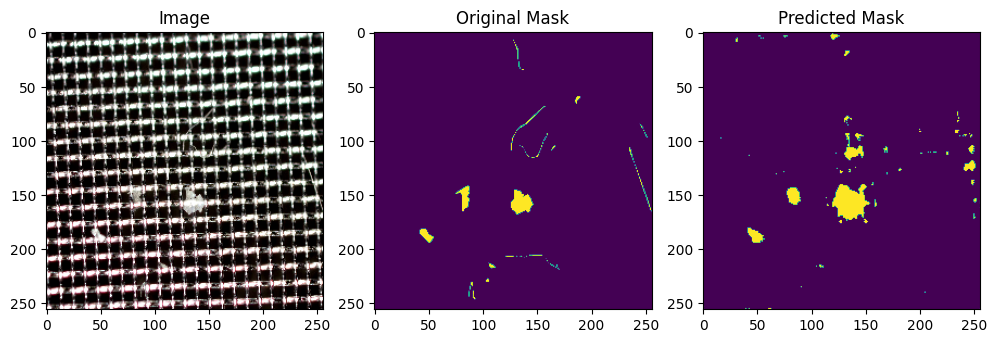

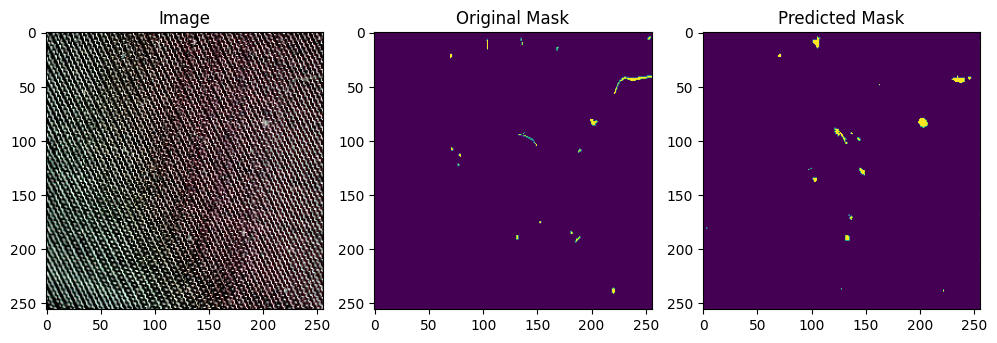

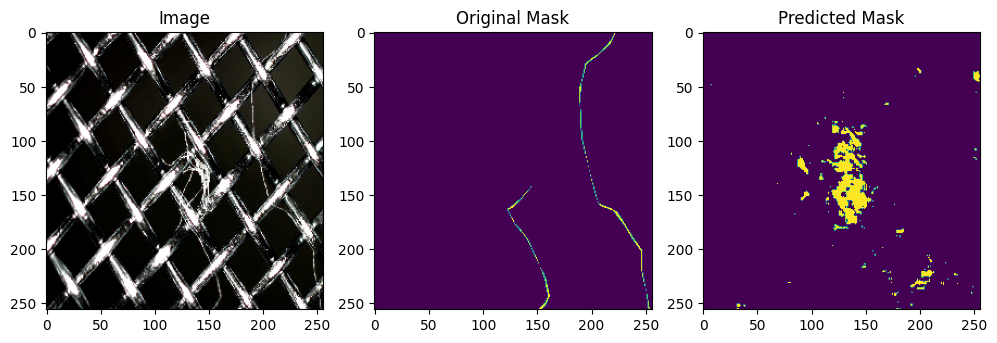

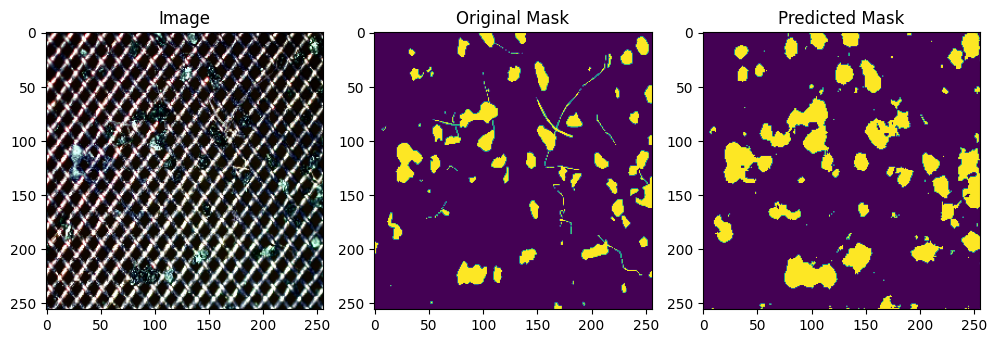

In [50]:
#USAGE random_test_evaluation

# load our model from disk and flash it to the current device
MODEL_PATH = '/content/drive/MyDrive/ResUnet-pytorch/pesi/epoca-37.pth'
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
#print(last_epoch,last_loss)

t = 0.505

random_test_evaluation(model,1,t)

## full test evaluation

In [46]:
#USAGE full_test_evaluation

# load our model from disk and flash it to the current device
MODEL_PATH = '/content/drive/MyDrive/ResUnet-pytorch/pesi/epoca-37.pth'
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
#print(last_epoch,last_loss)

t=0.505

precision_mean, recall_mean, f1_mean, mIoU = full_test_evaluation(model, t)
print(f"Precision mean: {precision_mean}")
print(f"Recall mean: {recall_mean}")
print(f"F1-Score mean: {f1_mean}")
print(f"mIoU: {mIoU}")

<ipython-input-46-7faa1cf6b530>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))


Precision mean: 0.155544039280831
Recall mean: 0.27012721272797613
F1-Score mean: 0.16737684628963995
mIoU: 0.10049502358676177


## threshold check

In [ ]:
#USAGE treshold

# load our model from disk and flash it to the current device
MODEL_PATH = '/content/drive/MyDrive/ResUnet-pytorch/pesi/epoca-145.pth'
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
#print(last_epoch,last_loss)


random_test_evaluation_t(model,1)

## overfitting check

In [ ]:
#overfitting

def overfitting_check(model, treshold):

	# load the image paths in our testing file and randomly select n image paths
  IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/0_train/'
  MASK_TEST_PATH = '/content/drive/MyDrive/dataset/0_train_bi/'
  #imagePaths = [os.path.join(IMAGE_TEST_PATH, f) for f in os.listdir(IMAGE_TEST_PATH) if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  image_paths = os.listdir(IMAGE_TEST_PATH)
  imagePaths = np.random.choice(image_paths, size=202)

  precision_list = []
  recall_list = []
  f1_list = []
  iou_list = []

  #treshold = 0.1

  # iterate over the test image paths: 202 images
  for path in imagePaths:

    # make predictions
    orig, gtMask, predMask = make_predictions(model, os.path.join(IMAGE_TEST_PATH, path), MASK_TEST_PATH, device, treshold)

    precision_list.append(precision(gtMask, predMask, treshold))
    recall_list.append(recall(gtMask, predMask, treshold))
    f1_list.append(f1_score(gtMask, predMask, treshold))
    iou_list.append(iou(gtMask, predMask, treshold))

  #salva ciscuna lista in file npy
  data_graph = '/content/drive/MyDrive/ResUnet-pytorch/grafici/'
  with open(data_graph + 'precision_list_train.npy', 'wb') as f:
      np.save(f, np.array(precision_list))
  with open(data_graph + 'recall_list_train.npy', 'wb') as f:
      np.save(f, np.array(recall_list))
  with open(data_graph + 'f1_list_train.npy', 'wb') as f:
      np.save(f, np.array(f1_list))
  with open(data_graph + 'iou_list_train.npy', 'wb') as f:
      np.save(f, np.array(iou_list))

  return np.mean(precision_list), np.mean(recall_list), np.mean(f1_list), np.mean(iou_list)



#USAGE full_test_evaluation

# load our model from disk and flash it to the current device
MODEL_PATH = '/content/drive/MyDrive/ResUnet-pytorch/pesi/epoca-95.pth'
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
#print(last_epoch,last_loss)

t = 0.5

precision_mean, recall_mean, f1_mean, mIoU = overfitting_check(model,t)
print(f"Precision mean: {precision_mean}")
print(f"Recall mean: {recall_mean}")
print(f"F1-Score mean: {f1_mean}")
print(f"mIoU: {mIoU}")

<ipython-input-32-ce1b5a5a9cd6>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))


Precision mean: 0.009968974802753654
Recall mean: 0.4975247524744009
F1-Score mean: 0.018013777205906707
mIoU: 0.00943541688853294


# GRAFICI

## loss in train

In [ ]:
loss_list = []
for i in range(0,146):
  MODEL_PATH = f'/content/drive/MyDrive/ResUnet-pytorch/pesi/epoca-{str(i)}.pth'
  checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cuda'))
  last_loss = checkpoint['loss']
  loss_list.append(last_loss)
  print(last_loss)

with open( data_graph + 'NEW_loss_list.npy', 'wb') as f:             # ab = append binary
  np.save(f, loss_list)

0.027428763927679498
0.02718533678374675
0.027078118440710276
0.02721941252830605
0.02674369818867709
0.026785016607444624
0.026750161741778303
0.026552551705086854
0.026704403441338665
0.035983391746223364
0.03598761422322996
0.036160015358501614
0.035318680935772895
0.035495707680280125
0.03547212793051905


<Figure size 1000x500 with 0 Axes>

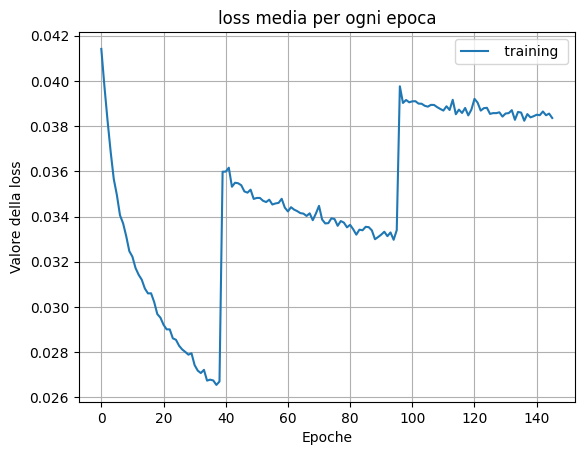

In [45]:
fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
plt.title('loss media per ogni epoca')

plt.xlabel('Epoche')
plt.ylabel('Valore della loss')

loss_t = np.load(data_graph + 'NEW_loss_list.npy')
#37

ax.plot(loss_t, label = ' training ')

# Legenda del plot
plt.legend()
plt.grid()

#fig.savefig(data_graph + 'metriche.png', bbox_inches='tight',  dpi=100)

## **GRAFICI MEDIA ARITMETICA**

(202,)


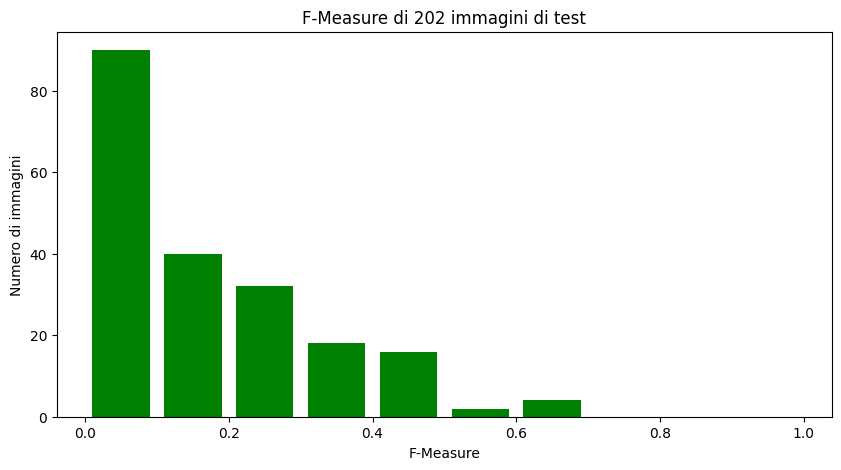

In [53]:
f1 = np.load(data_graph + 'f1_list.npy')
print(f1.shape)

fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0, 1)      # Media aritmetica
bins = 10

# Plot di un istogramma
plt.hist(f1, bins, value, color = 'green', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('F-Measure')
# Etichetta asse y
plt.ylabel('Numero di immagini')
# Titolo del plot
plt.title('F-Measure di 202 immagini di test')

#fig.savefig(data_graph + 'fm.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()

(202,)


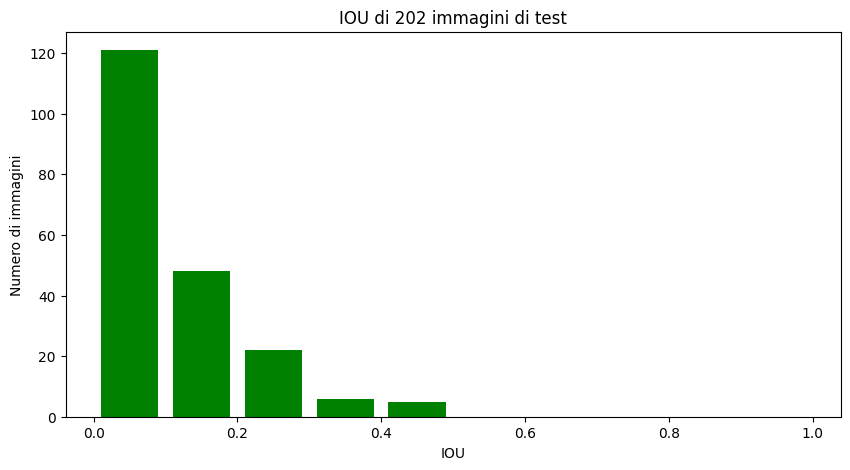

In [51]:
iou = np.load(data_graph + 'iou_list.npy')
print(f1.shape)

fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0, 1)      # Media aritmetica
bins = 10

# Plot di un istogramma
plt.hist(iou, bins, value, color = 'green', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('IOU')
# Etichetta asse y
plt.ylabel('Numero di immagini')
# Titolo del plot
plt.title('IOU di 202 immagini di test')

#fig.savefig(data_graph + 'fm.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()

## **GRAFICI MEDIA TRONCATA**

(202,)


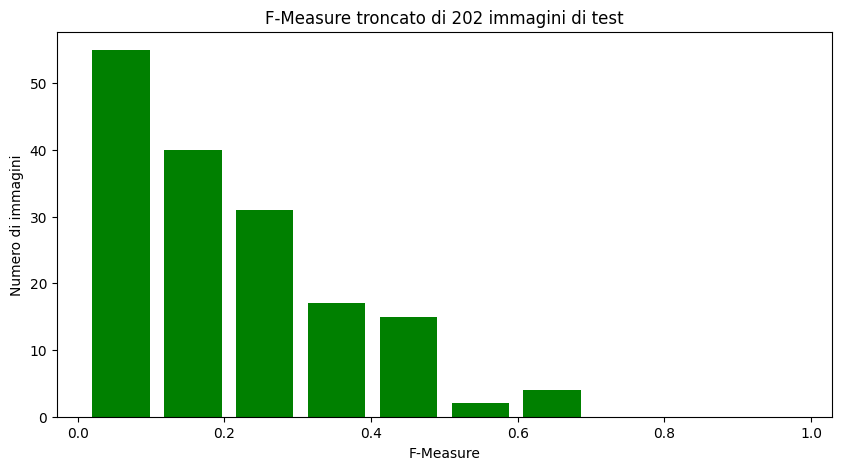

In [56]:
f1 = np.load(data_graph + 'f1_list.npy')
print(f1.shape)

fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0.01,0.99)     # Media troncata eliminando valori estremi
bins = 10

# Plot di un istogramma
plt.hist(f1, bins, value, color = 'green', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('F-Measure')
# Etichetta asse y
plt.ylabel('Numero di immagini')
# Titolo del plot
plt.title('F-Measure troncato di 202 immagini di test')

#fig.savefig(data_graph + 'fm-troncato.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()

(202,)


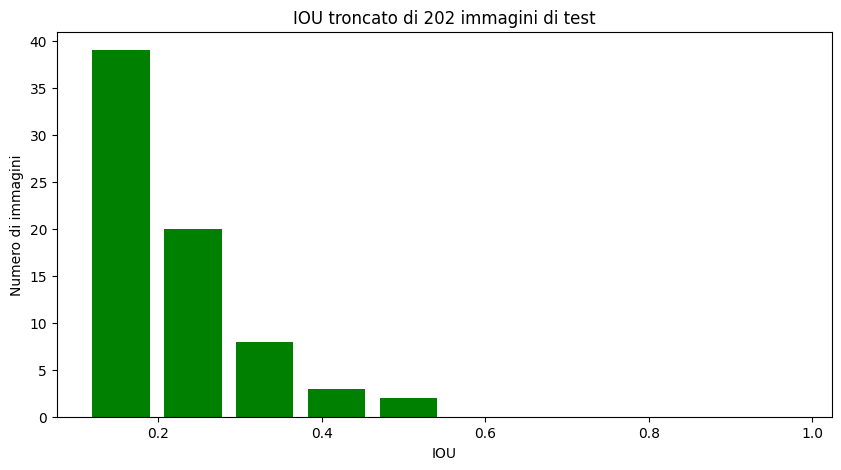

In [58]:
iou = np.load(data_graph + 'iou_list.npy')
print(f1.shape)

fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0.11, 0.99)      # Media aritmetica
bins = 10

# Plot di un istogramma
plt.hist(iou, bins, value, color = 'green', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('IOU')
# Etichetta asse y
plt.ylabel('Numero di immagini')
# Titolo del plot
plt.title('IOU troncato di 202 immagini di test')

#fig.savefig(data_graph + 'fm.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()